9.42


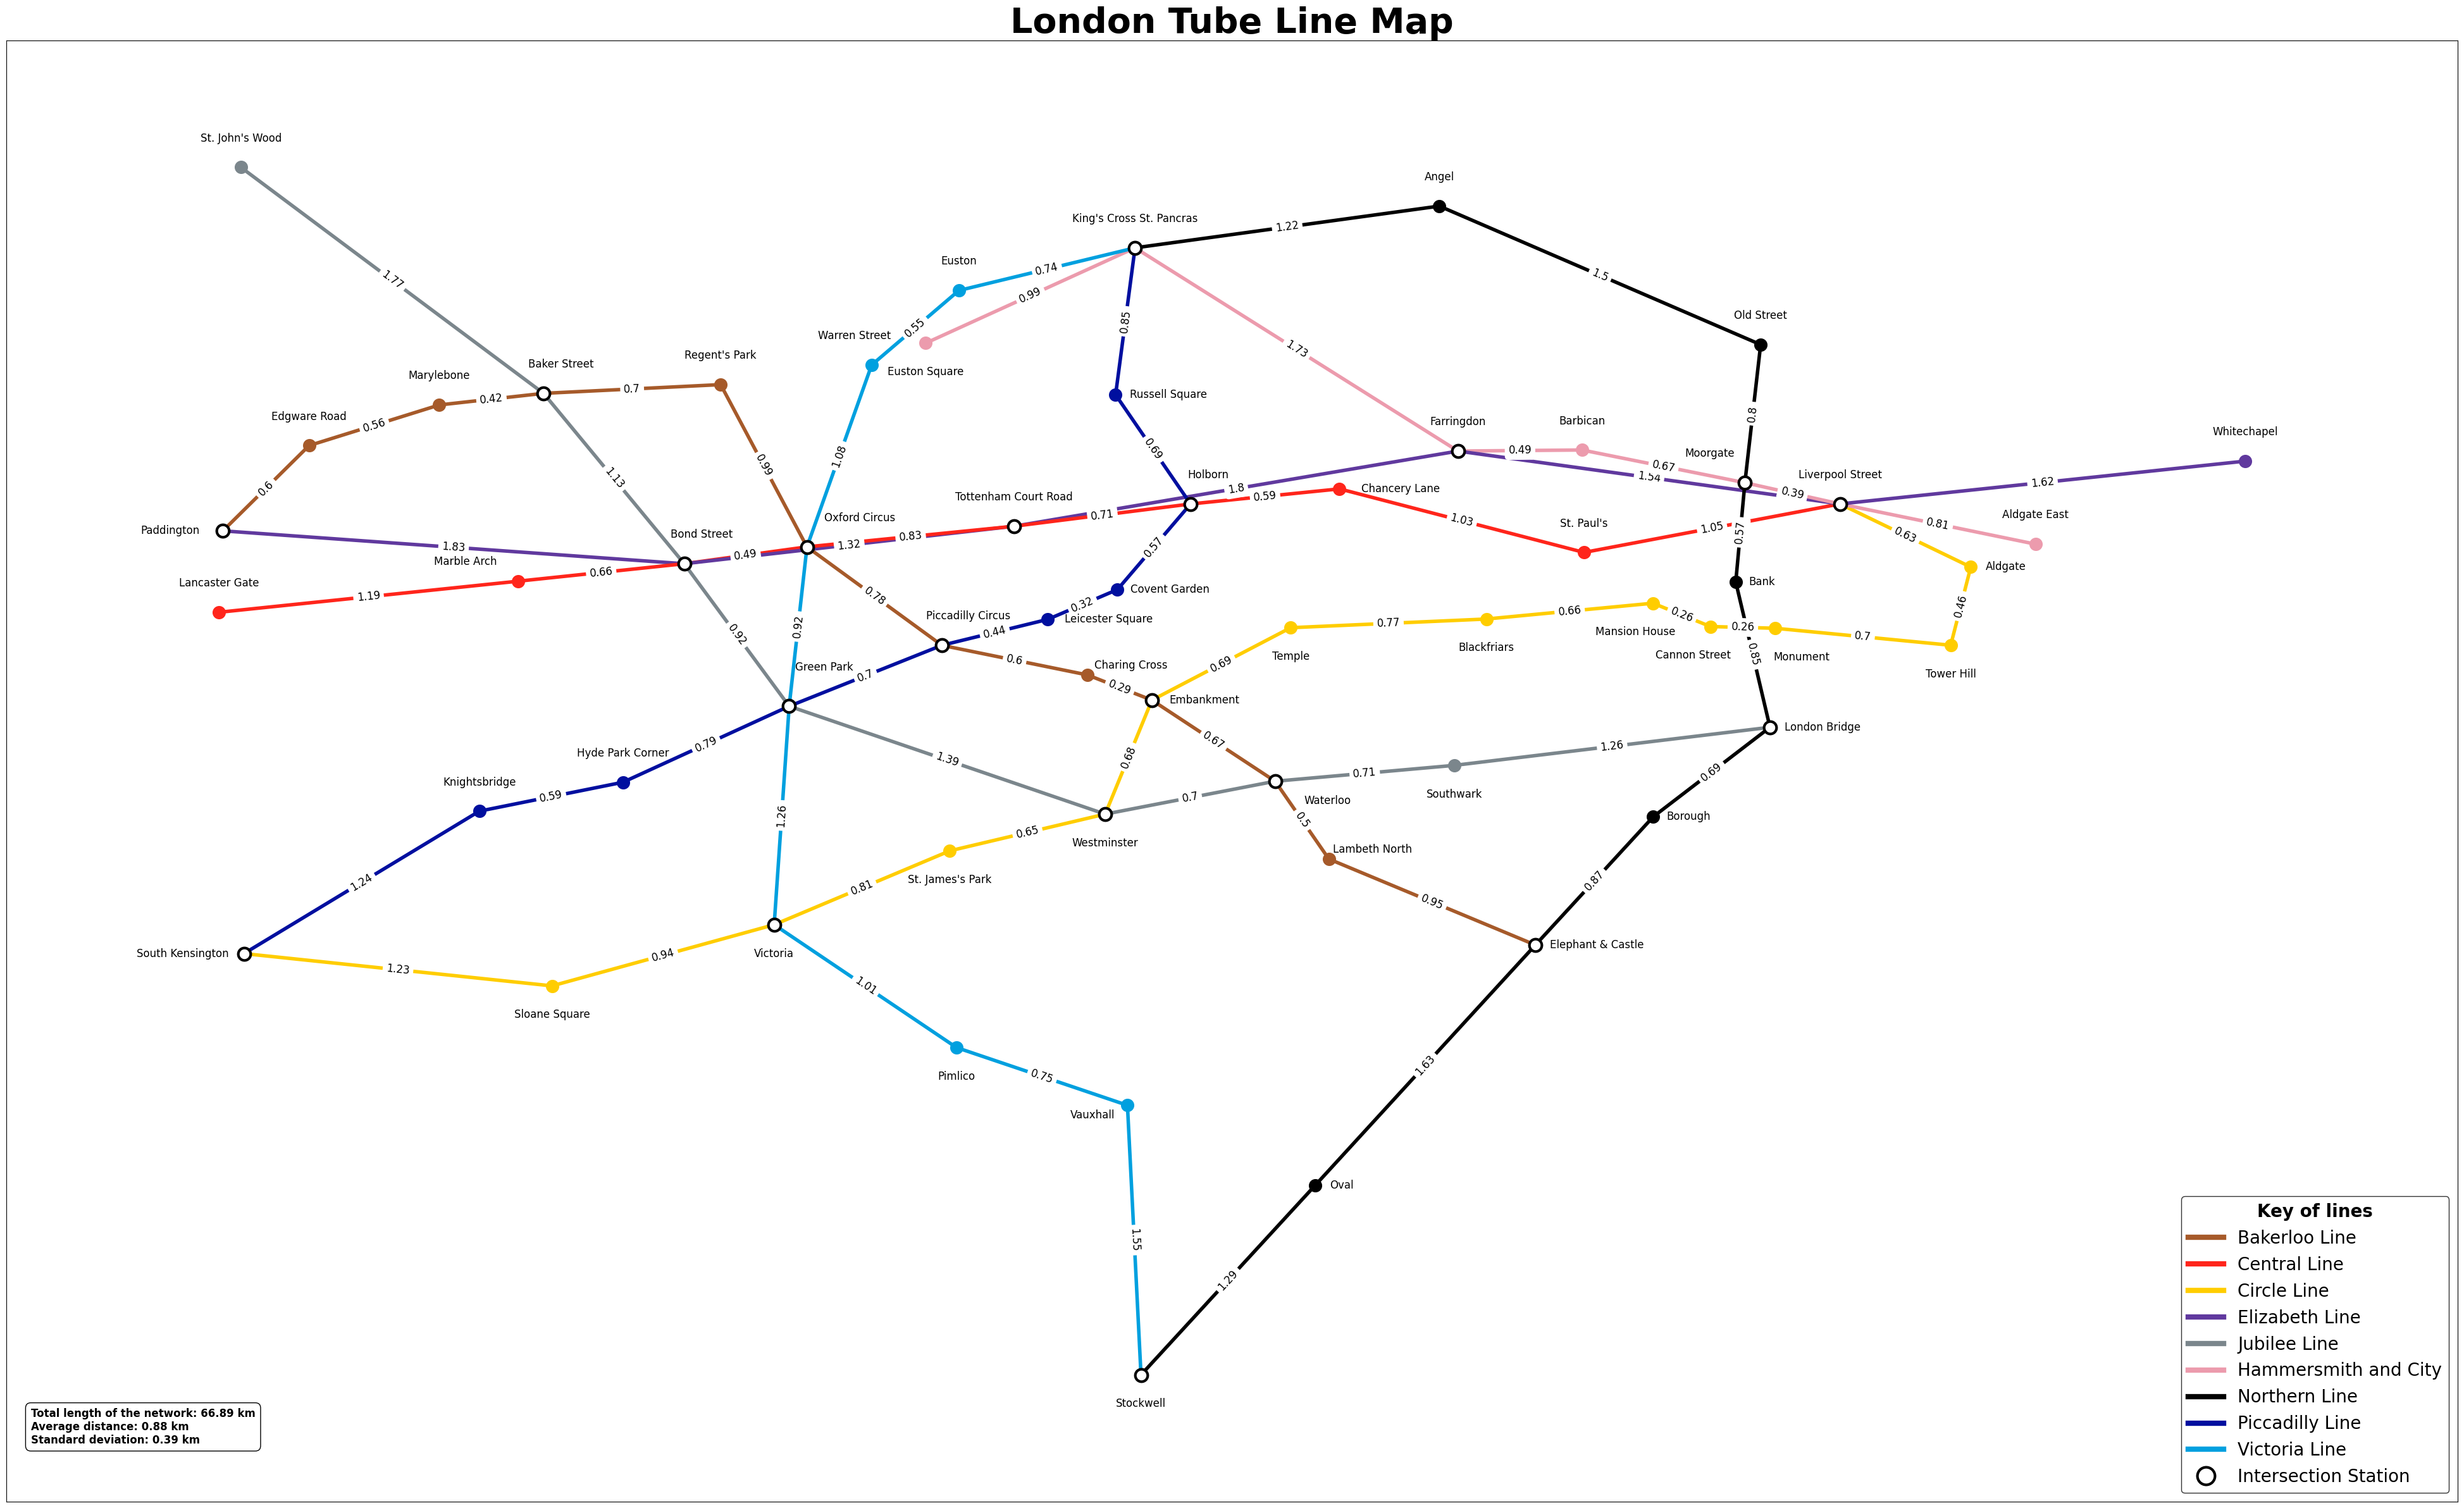

In [ ]:
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

# ------------------- Data Loading -------------------
# Load the CSV file
file_path = '../csv/station_coordinates.csv'
stations_data = pd.read_csv(file_path)
stations_data.columns = stations_data.columns.str.strip()

# Load the line color data
color_file_path = '../csv/line_colors.csv'
color_data = pd.read_csv(color_file_path)
color_data.columns = color_data.columns.str.strip()

# ------------------- Corlor Convert Function -------------------
# Convert RGB to HEX in the color mapping
def rgb_to_hex(r, g, b):
    return f'#{r:02x}{g:02x}{b:02x}'

color_data['HexColor'] = color_data.apply(
    lambda row: rgb_to_hex(row['ColorR'], row['ColorG'], row['ColorB']), axis=1
)

# Create a dictionary for line colors
color_mapping = dict(zip(color_data['Line'], color_data['HexColor']))

# ------------------- Haversine Function -------------------
def haversine(lat1, lon1, lat2, lon2):
    R = 6371  # Earth radius in kilometers
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = np.sin(dlat / 2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
    return R * c

# ------------------- Graph Data Preparation -------------------
bakerloo_line_edges = [
    ("Elephant & Castle", "Lambeth North"),
    ("Lambeth North", "Waterloo"),
    ("Waterloo", "Embankment"),
    ("Embankment", "Charing Cross"),
    ("Charing Cross", "Piccadilly Circus"),
    ("Piccadilly Circus", "Oxford Circus"),
    ("Oxford Circus", "Regent's Park"),
    ("Regent's Park", "Baker Street"),
    ("Baker Street", "Marylebone"),
    ("Marylebone", "Edgware Road"),
    ("Edgware Road", "Paddington"),
]

central_line_edges = [
    ("Lancaster Gate", "Marble Arch"),
    ("Marble Arch", "Bond Street"),
    ("Bond Street", "Oxford Circus"),
    ("Oxford Circus", "Tottenham Court Road"),
    ("Tottenham Court Road", "Holborn"),
    ("Holborn", "Chancery Lane"),
    ("Chancery Lane", "St. Paul's"),
    ("St. Paul's", "Liverpool Street"),
]

circle_line_edges = [
    ("Liverpool Street", "Aldgate"),
    ("Aldgate", "Tower Hill"),
    ("Tower Hill", "Monument"),
    ("Monument", "Cannon Street"),
    ("Cannon Street", "Mansion House"),
    ("Mansion House", "Blackfriars"),
    ("Blackfriars", "Temple"),
    ("Temple", "Embankment"),
    ("Embankment", "Westminster"),
    ("Westminster", "St. James's Park"),
    ("St. James's Park", "Victoria"),
    ("Victoria", "Sloane Square"),
    ("Sloane Square", "South Kensington"),
]

elizabeth_line_edges = [
    ("Whitechapel", "Liverpool Street"),
    ("Liverpool Street", "Farringdon"),
    ("Farringdon", "Tottenham Court Road"),
    ("Tottenham Court Road", "Bond Street"),
    ("Bond Street", "Paddington"),
]


hammersmith_and_city_line_edges = [
    ("Euston Square", "King's Cross St. Pancras"),
    ("King's Cross St. Pancras", "Farringdon"),
    ("Farringdon", "Barbican"),
    ("Barbican", "Moorgate"),
    ("Moorgate", "Liverpool Street"),
    ("Liverpool Street", "Aldgate East"),
]

jubilee_line_edges = [
    ("St. John's Wood","Baker Street"),
    ("Baker Street", "Bond Street"),
    ("Bond Street", "Green Park"),
    ("Green Park", "Westminster"),
    ("Westminster", "Waterloo"),
    ("Waterloo", "Southwark"),
    ("Southwark", "London Bridge"),
]

piccadilly_line_edges = [
    ("South Kensington", "Knightsbridge"),
    ("Knightsbridge", "Hyde Park Corner"),
    ("Hyde Park Corner", "Green Park"),
    ("Green Park", "Piccadilly Circus"),
    ("Piccadilly Circus", "Leicester Square"),
    ("Leicester Square", "Covent Garden"),
    ("Covent Garden", "Holborn"),
    ("Holborn", "Russell Square"),
    ("Russell Square", "King's Cross St. Pancras"),
]

victoria_line_edges = [
    ("Stockwell", "Vauxhall"),
    ("Vauxhall", "Pimlico"),
    ("Pimlico", "Victoria"),
    ("Victoria", "Green Park"),
    ("Green Park", "Oxford Circus"),
    ("Oxford Circus", "Warren Street"),
    ("Warren Street", "Euston"),
    ("Euston", "King's Cross St. Pancras"),
]

northern_line_edges = [
    ("Stockwell", "Oval"),
    ("Oval", "Elephant & Castle"),
    ("Elephant & Castle", "Borough"),
    ("Borough", "London Bridge"),
    ("London Bridge", "Bank"),
    ("Bank", "Moorgate"),
    ("Moorgate", "Old Street"),
    ("Old Street", "Angel"),
    ("Angel", "King's Cross St. Pancras"),
]

edges = []
edge_labels = {}

for edge_list, line_color in [
    (bakerloo_line_edges, color_mapping['Bakerloo']),
    (central_line_edges, color_mapping['Central']),
    (circle_line_edges, color_mapping['Circle']),
    (elizabeth_line_edges, color_mapping['Elizabeth']),
    (hammersmith_and_city_line_edges, color_mapping['Hammersmith and City']),
    (northern_line_edges, color_mapping['Northern']),
    (jubilee_line_edges, color_mapping['Jubilee']),
    (piccadilly_line_edges, color_mapping['Piccadilly']),
    (victoria_line_edges, color_mapping['Victoria']),
]:
    for edge in edge_list:
        station1 = stations_data[stations_data['Station'] == edge[0]].iloc[0]
        station2 = stations_data[stations_data['Station'] == edge[1]].iloc[0]
        distance = haversine(station1['Latitude'], station1['Longitude'],
                             station2['Latitude'], station2['Longitude'])
        edges.append((edge[0], edge[1], round(distance, 2), line_color))
        edge_labels[(edge[0], edge[1])] = f"{round(distance, 2)}"


G = nx.Graph()
for _, row in stations_data.iterrows():
    G.add_node(row['Station'], pos=(row['Longitude'], row['Latitude']))

for edge in edges:
    G.add_edge(edge[0], edge[1], color=edge[3], weight=edge[2])

stations_by_line = {
    'Bakerloo': set(station for edge in bakerloo_line_edges for station in edge),
    'Central': set(station for edge in central_line_edges for station in edge),
    'Circle': set(station for edge in circle_line_edges for station in edge),
    'Elizabeth': set(station for edge in elizabeth_line_edges for station in edge),
    'Hammersmith and City': set(station for edge in hammersmith_and_city_line_edges for station in edge),
    'Northern': set(station for edge in northern_line_edges for station in edge),
    'Jubilee': set(station for edge in jubilee_line_edges for station in edge),
    'Piccadilly': set(station for edge in piccadilly_line_edges for station in edge),
    'Victoria': set(station for edge in victoria_line_edges for station in edge),
}

intersection_stations = set()
for station in G.nodes():
    line_count = sum(station in stations_by_line[line] for line in stations_by_line)
    if line_count >= 2:
        intersection_stations.add(station)

# Filter out nodes not in any line
node_colors = {}
for node in G.nodes():
    if node in intersection_stations:
        node_colors[node] = 'ffffff'
    elif node in stations_by_line['Bakerloo']:
        node_colors[node] = color_mapping['Bakerloo']
    elif node in stations_by_line['Central']:
        node_colors[node] = color_mapping['Central']
    elif node in stations_by_line['Circle']:
        node_colors[node] = color_mapping['Circle']
    elif node in stations_by_line['Elizabeth']:
        node_colors[node] = color_mapping['Elizabeth']
    elif node in stations_by_line['Hammersmith and City']:
        node_colors[node] = color_mapping['Hammersmith and City']
    elif node in stations_by_line['Northern']:
        node_colors[node] = color_mapping['Northern']
    elif node in stations_by_line['Jubilee']:
        node_colors[node] = color_mapping['Jubilee']
    elif node in stations_by_line['Piccadilly']:
        node_colors[node] = color_mapping['Piccadilly']
    elif node in stations_by_line['Victoria']:
        node_colors[node] = color_mapping['Victoria']

# Filter graph to only include relevant nodes
G_filtered = G.subgraph(node_colors.keys())
# Adjust labels based on initial positions
positions = nx.get_node_attributes(G_filtered, 'pos')
# ------------------- Adjust labels based on initial positions -------------------
label_pos_adjustments = {
    "Aldgate": (positions["Aldgate"][0] + 0.002, positions["Aldgate"][1]),
    "Aldgate East": (positions["Aldgate East"][0], positions["Aldgate East"][1] + 0.0015),
    "Angel": (positions["Angel"][0], positions["Angel"][1] + 0.0015),
    "Baker Street": (positions["Baker Street"][0] + 0.001, positions["Baker Street"][1] + 0.0015),
    "Bank": (positions["Bank"][0] + 0.0015, positions["Bank"][1]),
    "Barbican": (positions["Barbican"][0], positions["Barbican"][1] + 0.0015),
    "Borough": (positions["Borough"][0] + 0.002, positions["Borough"][1]),
    "Bond Street": (positions["Bond Street"][0] + 0.001, positions["Bond Street"][1] + 0.0015),
    "Blackfriars": (positions["Blackfriars"][0], positions["Blackfriars"][1] - 0.0015),
    "Cannon Street": (positions["Cannon Street"][0] - 0.001, positions["Cannon Street"][1] - 0.0015),
    "Chancery Lane": (positions["Chancery Lane"][0] + 0.0035, positions["Chancery Lane"][1]),
    "Charing Cross": (positions["Charing Cross"][0] + 0.0025, positions["Charing Cross"][1]+ 0.0005),
    "Covent Garden": (positions["Covent Garden"][0] + 0.003, positions["Covent Garden"][1]),
    "Euston": (positions["Euston"][0], positions["Euston"][1] + 0.0015),
    "Euston Square": (positions["Euston Square"][0], positions["Euston Square"][1] - 0.0015),
    "Elephant & Castle": (positions["Elephant & Castle"][0] + 0.0035, positions["Elephant & Castle"][1]),
    "Edgware Road": (positions["Edgware Road"][0], positions["Edgware Road"][1] + 0.0015),
    "Embankment": (positions["Embankment"][0] + 0.003, positions["Embankment"][1]),
    "Farringdon": (positions["Farringdon"][0], positions["Farringdon"][1] + 0.0015),
    "Green Park": (positions["Green Park"][0] + 0.002, positions["Green Park"][1] + 0.002),
    "Holborn": (positions["Holborn"][0] + 0.001, positions["Holborn"][1] + 0.0015),
    "Hyde Park Corner": (positions["Hyde Park Corner"][0], positions["Hyde Park Corner"][1] + 0.0015),
    "King's Cross St. Pancras": (positions["King's Cross St. Pancras"][0], positions["King's Cross St. Pancras"][1] + 0.0015),
    "Knightsbridge": (positions["Knightsbridge"][0], positions["Knightsbridge"][1] + 0.0015),
    "Lambeth North": (positions["Lambeth North"][0] + 0.0025, positions["Lambeth North"][1] + 0.0005),
    "Lancaster Gate": (positions["Lancaster Gate"][0], positions["Lancaster Gate"][1] + 0.0015),
    "Leicester Square": (positions["Leicester Square"][0] + 0.0035, positions["Leicester Square"][1]),
    "Liverpool Street": (positions["Liverpool Street"][0], positions["Liverpool Street"][1] + 0.0015),
    "London Bridge": (positions["London Bridge"][0] + 0.003, positions["London Bridge"][1]),
    "Marble Arch": (positions["Marble Arch"][0] - 0.003, positions["Marble Arch"][1] + 0.001),
    "Marylebone": (positions["Marylebone"][0], positions["Marylebone"][1] + 0.0015),
    "Mansion House": (positions["Mansion House"][0] - 0.001, positions["Mansion House"][1] - 0.0015),
    "Monument": (positions["Monument"][0] + 0.0015, positions["Monument"][1] - 0.0015),
    "Moorgate": (positions["Moorgate"][0] - 0.002, positions["Moorgate"][1] + 0.0015),
    "Old Street": (positions["Old Street"][0], positions["Old Street"][1] + 0.0015),
    "Oxford Circus": (positions["Oxford Circus"][0] + 0.003, positions["Oxford Circus"][1] + 0.0015),
    "Oval": (positions["Oval"][0] + 0.0015, positions["Oval"][1]),
    "Paddington": (positions["Paddington"][0] - 0.003, positions["Paddington"][1]),
    "Piccadilly Circus": (positions["Piccadilly Circus"][0] + 0.0015, positions["Piccadilly Circus"][1] + 0.0015),
    "Pimlico": (positions["Pimlico"][0], positions["Pimlico"][1] - 0.0015),
    "Regent's Park": (positions["Regent's Park"][0], positions["Regent's Park"][1] + 0.0015),
    "Russell Square": (positions["Russell Square"][0] + 0.003, positions["Russell Square"][1]),
    "Sloane Square": (positions["Sloane Square"][0], positions["Sloane Square"][1] - 0.0015),
    "South Kensington": (positions["South Kensington"][0] - 0.0035, positions["South Kensington"][1]),
    "Southwark": (positions["Southwark"][0], positions["Southwark"][1] - 0.0015),
    "St. James's Park": (positions["St. James's Park"][0], positions["St. James's Park"][1] - 0.0015),
    "St. John's Wood": (positions["St. John's Wood"][0], positions["St. John's Wood"][1] + 0.0015), 
    "St. Paul's": (positions["St. Paul's"][0], positions["St. Paul's"][1] + 0.0015),
    "Stockwell": (positions["Stockwell"][0], positions["Stockwell"][1] - 0.0015),
    "Temple": (positions["Temple"][0], positions["Temple"][1] - 0.0015),
    "Tottenham Court Road": (positions["Tottenham Court Road"][0], positions["Tottenham Court Road"][1] + 0.0015),
    "Tower Hill": (positions["Tower Hill"][0], positions["Tower Hill"][1] - 0.0015),
    "Vauxhall": (positions["Vauxhall"][0] - 0.002, positions["Vauxhall"][1] - 0.0005),
    "Victoria": (positions["Victoria"][0], positions["Victoria"][1] - 0.0015),
    "Warren Street": (positions["Warren Street"][0] - 0.001, positions["Warren Street"][1] + 0.0015),
    "Waterloo": (positions["Waterloo"][0] + 0.003, positions["Waterloo"][1] - 0.001),
    "Westminster": (positions["Westminster"][0], positions["Westminster"][1] - 0.0015),
    "Whitechapel": (positions["Whitechapel"][0], positions["Whitechapel"][1] + 0.0015),
}

# ------------------- Graph Visualization -------------------
plt.figure(figsize=(50, 30))

# Draw non-intersection nodes
for node in G_filtered.nodes():
    if node not in intersection_stations:
        nx.draw_networkx_nodes(
            G_filtered,
            pos=positions,
            nodelist=[node],
            node_size=200,
            node_color=node_colors[node]
        )

# Draw intersection nodes
for node in intersection_stations:
    x, y = positions[node]
    plt.scatter(x, y, s=200, color='#ffffff', edgecolor='#000000', linewidth=3, zorder=3)

# Draw edges with colors
edge_colors = [G_filtered[u][v]['color'] for u, v in G_filtered.edges()]
nx.draw_networkx_edges(
    G_filtered,
    pos=positions,
    edge_color=edge_colors,
    width=4
)

# Draw labels with adjusted positions
nx.draw_networkx_labels(
    G_filtered,
    pos=label_pos_adjustments,
    font_size=12,
    font_weight='normal'
)

# Draw labels for edges (distances in km)
nx.draw_networkx_edge_labels(
    G_filtered,
    pos=positions,
    edge_labels=edge_labels,
    font_size=12,
    font_weight='normal'
)

legend_elements = [
    plt.Line2D([0], [0], color=color_mapping['Bakerloo'], lw=6, label='Bakerloo Line'),
    plt.Line2D([0], [0], color=color_mapping['Central'], lw=6, label='Central Line'),
    plt.Line2D([0], [0], color=color_mapping['Circle'], lw=6, label='Circle Line'),
    plt.Line2D([0], [0], color=color_mapping['Elizabeth'], lw=6, label='Elizabeth Line'),
    plt.Line2D([0], [0], color=color_mapping['Jubilee'], lw=6, label='Jubilee Line'),
    plt.Line2D([0], [0], color=color_mapping['Hammersmith and City'], lw=6, label='Hammersmith and City'),
    plt.Line2D([0], [0], color=color_mapping['Northern'], lw=6, label='Northern Line'),
    plt.Line2D([0], [0], color=color_mapping['Piccadilly'], lw=6, label='Piccadilly Line'),
    plt.Line2D([0], [0], color=color_mapping['Victoria'], lw=6, label='Victoria Line'),
    plt.Line2D([0], [0], marker='o', color='white', markerfacecolor='#ffffff', 
               markeredgecolor='#000000', markersize=20, markeredgewidth=3, label='Intersection Station')
]

legend = plt.legend(handles=legend_elements, loc='lower right', fontsize=20, frameon=True, ncol=1, title="Key of lines")
legend.get_frame().set_edgecolor('#000000')
legend.get_frame().set_linewidth(1)
legend.get_title().set_fontsize('20')
legend.get_title().set_fontweight('bold')


# ------------------- Distance Statistics -------------------
edges_data = pd.DataFrame(edges, columns=['Station1', 'Station2', 'Distance', 'LineColor'])


total_length = round(edges_data['Distance'].sum(), 2)
average_distance = round(edges_data['Distance'].mean(), 2)
std_distance = round(edges_data['Distance'].std(), 2)
plt.text(
    0.01, 0.04,  # Position in axis coordinates
    f"Total length of the network: {total_length} km\n"
    f"Average distance: {average_distance} km\n"
    f"Standard deviation: {std_distance} km",
    fontsize=12,
    fontweight='bold',
    color='black',
    transform=plt.gca().transAxes,  # Use axis coordinates
    bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.5')  # Box styling
)

plt.title("London Tube Line Map", fontsize=40, fontweight='bold')
plt.show()